<div style="text-align: center;">
    <h1 style="color: #3498db;">Simple Text-based similarity retrieval</h1>
    <h2 style="color: #3498db;"> </h2>
</div>

-------------------------------------------------------------

In [4]:
# Imports and load data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# disable annoying warnings
import warnings
warnings.filterwarnings('ignore')

#plot settings
sns.set(style="whitegrid")


In [5]:
#load data
songs_df = pd.read_csv('id_information_mmsr.tsv', sep='\t')
tfidf_df = pd.read_csv('id_lyrics_tf-idf_mmsr.tsv', sep='\t')
bert_df = pd.read_csv('id_lyrics_bert_mmsr.tsv', sep='\t')
w_to_vec = pd.read_csv('id_lyrics_word2vec_mmsr.tsv', sep='\t')

In [6]:
# Lets have a look at the data
songs_df

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


I choose an example song to show the results of the function implemented. Later in the notebook, 2 more songs are choosen to allow output comparison.

In [7]:
# Example song
query_song = {'id': '3uNmJmetcUAMc9WR', 'artist': ' The Beatles', 'song': 'Strawberry Fields Forever - Remastered 2009', 'album': 'Magical Mystery Tour (Remastered)'}
N = 10  

RANDOM BASELINE: <br>
For the implementation of the random function we will simply use numpy's sample function. This will return the top N songs.


In [8]:
# Random Baseline
def random_baseline(query_id, songs_df, N):
    songs = songs_df[songs_df['id'] != query_id]   
    top_random_songs = songs.sample(N)
    return top_random_songs


In [9]:
random_songs = random_baseline(query_song['id'], songs_df, N)
print("-"*30)
print(f"Random Baseline Top {N} recommendations for: {query_song['song']}")
print("-"*30)
display(random_songs.style.hide(axis="index"))

------------------------------
Random Baseline Top 10 recommendations for: Strawberry Fields Forever - Remastered 2009
------------------------------


id,artist,song,album_name
9gY0mHPFBXLqmWFR,Black Lips,Dirty Hands,Let It Bloom
ET8Bh73KA1KSbtTI,David Sylvian,When Poets Dreamed Of Angels,Secrets Of The Beehive (Remastered 2003)
mCZIG7YimsD01qwr,Bolt Thrower,Ritual,The IVth Crusade (Full Dynamic Range Edition)
zxI0u8m0EPvVhNeD,Little Richard,Tutti Frutti,Here's Little Richard (Deluxe Edition)
EtYe8YWsGvZmeRYM,Above & Beyond,Alchemy,Alchemy (i_o Remix)
FV5ABL6CRsNLnjkt,My Darkest Days,Can't Forget You,My Darkest Days
pF5dqrJwRreBWon6,Martinho Da Vila,Visgo De Jaca,Martinho da Vila
JDczWJmb7UM3ckEl,Rebecca Ferguson,Shoulder to Shoulder,Heaven
JEkKwAd83RlIWEDH,The Allman Brothers Band,Soulshine,Where It All Begins
6327rtdJcKr4bPUw,Ray Charles,I Got a Woman,"Ray Charles (aka: Hallelujah, I Love Her So)"


`text_based_retrieval` function uses cos_similarity measure in combination with the tf-idf method.



In [10]:
def text_based_retrieval(query_id, tfidf_df, songs_df, N, similarity_measure):
    try:
        query_vector = tfidf_df[tfidf_df['id'] == query_id].iloc[:, 1:].values    
        all_songs = tfidf_df.iloc[:, 1:].values 
    except Exception("Could not calculate query_vector and all_songs"):
        pass
    similarities = similarity_measure(query_vector, all_songs).flatten() 
    
    top_indices = similarities.argsort() 
    top_indices = top_indices[-N-1:-1][::-1] 
    top_similar_songs = songs_df.iloc[top_indices].copy()
    similarity_scores = similarities[top_indices]

    return top_similar_songs, similarity_scores

In [11]:
tf_idf_top_songs, tf_idf_similarity_scores = text_based_retrieval(query_song['id'], tfidf_df, songs_df, N, cosine_similarity)
tf_idf_top_songs['Similarity score'] = tf_idf_similarity_scores
print("-"*30)
print(f"\nText-based Retrieval Results for: {query_song['song']}")
print("-"*30)
display(tf_idf_top_songs.style.hide(axis="index"))

------------------------------

Text-based Retrieval Results for: Strawberry Fields Forever - Remastered 2009
------------------------------


id,artist,song,album_name,Similarity score
RST57JJzLeQ1Vx73,Animal Collective,My Girls,Merriweather Post Pavilion,0.676672
Bu1GIjPq54fw5CNZ,Michael Jackson,Why You Wanna Trip on Me,Dangerous,0.471950
aDsGY1HQMUdm0lH5,Pet Shop Boys,It's Alright,Introspective: Further Listening 1988-1989,0.419107
V0xgkL7AbAuTpp6J,Noisettes,Beat Of My Heart,Wild Young Hearts,0.404839
25nVhkWoblQ77VRo,Mark Ronson,Uptown Funk (feat. Bruno Mars),Uptown Special,0.382608
ouU9uuZdQfGpa1KM,Roxette,Fireworks,Crash! Boom! Bang! (2009 Version),0.332490
IrYTRNMnlfPeMrgF,Kent,Spökstad,B-sidor 95 - 00,0.323583
gxkL9vbNPaK7aU10,Pepper,Stone Love,Kona Town,0.321994
CUDLVFV5H2FxL5BA,Lindsay Lohan,Who Loves You,A Little More Personal (RAW),0.320417
NchU5VPjVu3KJHnH,Scars on Broadway,Babylon,Scars on Broadway,0.317336


`text_based_word2vec_retrieval` function uses cos_similarity measure in combination with the Word2Vec embedding.

In [12]:
def text_based_word2vec_retrieval(query_id, w_to_vec, songs_df, N, similarity_measure):
    try:
        query_vector = w_to_vec[w_to_vec['id'] == query_id].iloc[:, 1:].values    
        all_songs = w_to_vec.iloc[:, 1:].values
    except Exception("Could not calculate query_vector and all_songs."):
        pass
    
    similarities = similarity_measure(query_vector, all_songs).flatten()
    top_indices = similarities.argsort()
    top_indices = top_indices[-N-1:-1][::-1] 
    top_similar_songs = songs_df.iloc[top_indices].copy()
    similarity_scores = similarities[top_indices]

    return top_similar_songs, similarity_scores

In [13]:
w2v_top_songs, w2v_similarity_scores = text_based_word2vec_retrieval(query_song['id'], w_to_vec, songs_df, N, cosine_similarity)
w2v_top_songs['Similarity score'] = w2v_similarity_scores
print("-"*30)
print(f"\nWord2Vec-based Retrieval Results for: {query_song['song']}")
print("-"*30)
display(w2v_top_songs.style.hide(axis="index"))

------------------------------

Word2Vec-based Retrieval Results for: Strawberry Fields Forever - Remastered 2009
------------------------------


id,artist,song,album_name,Similarity score
sLh4EUeP6NL02A0V,Caravan Palace,Clash,Panic,0.910300
J7ks4R4hI0gmCoQK,Kansas,Sparks of the Tempest,Point Of Know Return,0.907906
SntTtuMXn1cTXpcG,Megadeth,The Killing Road,Youthanasia,0.907627
tULp3YuYJDraRSWx,The Brobecks,Goodnight Socialite,Violent Things,0.906519
vnQzBX4FAi2KDXwp,Demi Lovato,Gift of a Friend,Here We Go Again,0.901365
6MbDjLGnIVuYIWKx,Big Star,Thirteen,#1 Record,0.901320
PKLqZNDO4sU37S7s,Sara Bareilles,Lie to Me,Once Upon Another Time,0.900527
x8JCgF6eMmvq71ud,Ill Niño,This Is War,One Nation Underground [Special Edition],0.899067
UGSE5aV51CG4o64X,Marilyn Manson,Misery Machine,Portrait Of An American Family,0.898862
13hQ6n8ttb5TcX9v,Esben and the Witch,Iceland Spar,Wash the Sins Not Only the Face,0.898728


`text_based_bert_retrieval` function uses cos_similarity and then manhattan distance measures in combination with the BERT embedding.

In [14]:
def text_based_bert_retrieval(query_id, bert_df, songs_df, N, distance_measure):
    
    if query_id not in bert_df['id'].values:
        return None, None  

    try:
        query_vector = bert_df.loc[bert_df['id'] == query_id].iloc[:, 1:769].values.astype(float)
        all_vectors = bert_df.iloc[:, 1:769].values.astype(float)
    except Exception:
        pass

    if distance_measure == cosine_similarity:
        similarities = distance_measure(query_vector, all_vectors).flatten()
    else:
        # For other measures, convert distances to similarities
        distances = distance_measure(query_vector, all_vectors)
        similarities = 1 / (1 + distances.flatten())

    top_indices = np.argsort(similarities)[-N-1:][::-1] 
    if bert_df.iloc[top_indices[0]]['id'] == query_id:
        top_indices = top_indices[1:] 

    top_similar_songs = songs_df.iloc[top_indices].copy()
    similarity_scores = similarities[top_indices]
    top_similar_songs['Similarity score'] = similarity_scores

    return top_similar_songs, similarity_scores

In [15]:
# Example usage with Manhattan distance
print("-"*30)
print(f"\nBERT-based Retrieval Results for: {query_song['song']}")
print("-"*30)
bert_top_man_songs, bert_similarity_man_scores = text_based_bert_retrieval(query_song['id'], bert_df, songs_df, N, manhattan_distances)
bert_top_man_songs['Similarity score'] = bert_similarity_man_scores
display(bert_top_man_songs.style.hide(axis="index"))

------------------------------

BERT-based Retrieval Results for: Strawberry Fields Forever - Remastered 2009
------------------------------


id,artist,song,album_name,Similarity score
IAM3zYGj1mbCBXQn,Sarah McLachlan,U Want Me 2,Laws Of Illusion,0.068442
2WOoEGS0x26qywpx,Aerosmith,You See Me Crying,Toys In The Attic,0.067462
0UHzuflmmfXZkZNQ,The Amity Affliction,Greens Avenue,Chasing Ghosts,0.066510
9ziWMjkmNbJKtU8Y,Tame Impala,Nangs,Currents,0.066354
7nPWce3jydmZ2OXn,Emika,Wicked Game,Dva,0.066343
WZsn8QfmaYWEaoYV,Phoenix,Lost And Found,It's Never Been Like That (Deluxe Version),0.066134
32m5suoC94ytD8Ed,Ariana Grande,7 rings,"thank u, next",0.066058
mUrW1Gi5erJd7ObJ,Jason Derulo,Want To Want Me,Everything Is 4,0.065979
hphubyQkAucoqckI,Kitchens of Distinction,The 3rd Time We Opened the Capsule,Capsule - The Best Of KOD,0.065770
LZ37OMMnRhvQfKMR,Damien Jurado,The Last Great Washington State,The Horizon Just Laughed,0.065416


In [16]:
# Example usage with CosSim distance
print("-"*30)
print(f"\nBERT-based Retrieval Results for: {query_song['song']}")
print("-"*30)
bert_top_songs, bert_similarity_scores = text_based_bert_retrieval(query_song['id'], bert_df, songs_df, N, cosine_similarity)
bert_top_songs['Similarity score'] = bert_similarity_scores
display(bert_top_songs.style.hide(axis="index"))

------------------------------

BERT-based Retrieval Results for: Strawberry Fields Forever - Remastered 2009
------------------------------


id,artist,song,album_name,Similarity score
7nPWce3jydmZ2OXn,Emika,Wicked Game,Dva,0.663048
mUrW1Gi5erJd7ObJ,Jason Derulo,Want To Want Me,Everything Is 4,0.652595
IAM3zYGj1mbCBXQn,Sarah McLachlan,U Want Me 2,Laws Of Illusion,0.650186
b63GU7S8X3ddzOqZ,The Classic Crime,Say The Word,Albatross,0.645265
yhoyAVAJ53Igmh4j,Story of the Year,Until the Day I Die,Page Avenue (US Non-PA Version),0.644876
2WOoEGS0x26qywpx,Aerosmith,You See Me Crying,Toys In The Attic,0.639856
pc9XPONuDmTCwkCT,Alvaro Soler,Ella,Mar De Colores (Versión Extendida),0.639164
B3Yn5xLsbsID5yoE,Franz Ferdinand,Katherine Kiss Me,Tonight: Franz Ferdinand,0.637254
32m5suoC94ytD8Ed,Ariana Grande,7 rings,"thank u, next",0.635961
WZsn8QfmaYWEaoYV,Phoenix,Lost And Found,It's Never Been Like That (Deluxe Version),0.635922


Three song to compare results:


| **ID** | **ARTIST** | **SONG** | **ALBUM NAME** |
|--------------|----------|----------|----------|
| 3uNmJmetcUAMc9WR    |  The Beatles   | Strawberry Fields Forever - Remastered 2009   | Magical Mystery Tour (Remastered)   |
| E98c2LYjoR2PJrFW   | Depeche Mode   | Personal Jesus   | Personal Jesus   |
|mvLsLn5ivNmpeqfk |	Buena Vista Social Club	| El carretero	| Buena Vista Social Club|


In [18]:
def display_top_songs(query_id, N=10):
    
    random_songs = random_baseline(query_id, songs_df, N)
    tfidf_top_songs, tf_idf_similarity_scores = text_based_retrieval(query_id, tfidf_df, songs_df, N, cosine_similarity)
    word2vec_top_songs, w2v_similarity_scores = text_based_word2vec_retrieval(query_id, w_to_vec, songs_df, N, cosine_similarity)
    bert_top_songs, bert_similarity_scores = text_based_bert_retrieval(query_id, bert_df, songs_df, N, cosine_similarity)    
    top_songs_df = pd.concat({
        'Random Baseline': random_songs['song'].reset_index(drop=True),
        'TF-IDF': tfidf_top_songs['song'].reset_index(drop=True),
        'Word2Vec': word2vec_top_songs['song'].reset_index(drop=True),
        'BERT': bert_top_songs['song'].reset_index(drop=True),
        'BERT_Manhattan': bert_top_man_songs['song'].reset_index(drop=True)}, axis=1)
    
    similarity_scores_df = pd.DataFrame({
        'TF-IDF': tf_idf_similarity_scores,
        'Word2Vec': w2v_similarity_scores,
        'BERT': bert_similarity_scores,
       })
    similarity_scores_df.to_csv(f'similarity_scores_{query_id}.csv', index=False)
    display(top_songs_df) 


In [19]:
track_1 = {'id': '3uNmJmetcUAMc9WR', 'artist': 'The Beatles', 'song': 'Strawberry Fields Forever - Remastered 2009', 'album': 'Magical Mystery Tour (Remastered)'}
print("-"*30)
print(f"Top 10 similar song to: {track_1['song']} \n by: {track_1['artist']} \n")
print("-"*30)
display_top_songs(track_1['id'], 10)

------------------------------
Top 10 similar song to: Strawberry Fields Forever - Remastered 2009 
 by: The Beatles 

------------------------------


,Random Baseline,TF-IDF,Word2Vec,BERT,BERT_Manhattan
0,Eight,My Girls,Clash,Wicked Game,U Want Me 2
1,Head Carrier,Why You Wanna Trip on Me,Sparks of the Tempest,Want To Want Me,You See Me Crying
2,One Day At A Time,It's Alright,The Killing Road,U Want Me 2,Greens Avenue
3,27,Beat Of My Heart,Goodnight Socialite,Say The Word,Nangs
4,Même sous la pluie,Uptown Funk (feat. Bruno Mars),Gift of a Friend,Until the Day I Die,Wicked Game
5,Heaven Is a Truck,Fireworks,Thirteen,You See Me Crying,Lost And Found
6,Cross Out The Eyes,Spökstad,Lie to Me,Ella,7 rings
7,Have You in My Wilderness,Stone Love,This Is War,Katherine Kiss Me,Want To Want Me
8,Don't Stop,Who Loves You,Misery Machine,7 rings,The 3rd Time We Opened the Capsule
9,She's a Mystery to Me,Babylon,Iceland Spar,Lost And Found,The Last Great Washington State


In [20]:
track_2 = {'id': 'E98c2LYjoR2PJrFW', 'artist': 'Depeche Mode', 'song': 'Personal Jesus', 'album': 'Personal Jesus'}
print("-"*30)
print(f"Top 10 similar song to: {track_2['song']} \n by: {track_2['artist']}")
print("-"*30)
display_top_songs(track_2['id'], 10)

------------------------------
Top 10 similar song to: Personal Jesus 
 by: Depeche Mode
------------------------------


,Random Baseline,TF-IDF,Word2Vec,BERT,BERT_Manhattan
0,Iron Maiden,Love Is Not Enough,As I Ascend,Damaged,U Want Me 2
1,Ticky Ticky,Face to Face,Aggro,This Is Gospel,You See Me Crying
2,Encoder,Mercenaries,Big Machine,Apple Scruffs,Greens Avenue
3,Mariô,The Consequence,Hard Enough,Dream Glasses Off,Nangs
4,The Scientist,Milky Way,Drunken Sailor,I Ain't Gonna Stand For It,Wicked Game
5,They Just Don't Know You,Keep the Streets Empty for Me,No Lungs To Breathe,The Turn Of A Friendly Card (Part Two),Lost And Found
6,Umbabarauma,Safari Song,Calor do Amor,Trash Star,7 rings
7,Caveman,Losing You,When You Believe,Cartographist,Want To Want Me
8,Tears in Heaven,Ecoute,Holy Mondays,Soft Rock Star,The 3rd Time We Opened the Capsule
9,Um Cara de Sorte,This Is Shangrila,Keep the Car Running,I Can Change,The Last Great Washington State


In [21]:
track_3 = {'id': 'mvLsLn5ivNmpeqfk', 'artist': 'Buena Vista Social Club', 'song': 'El carretero', 'album': 'Buena Vista Social Club'}
print("-"*30)
print(f"Top 10 similar song to: {track_3['song']} \n by: {track_3['artist']}")
print("-"*30)
display_top_songs(track_3['id'], 10)

------------------------------
Top 10 similar song to: El carretero 
 by: Buena Vista Social Club
------------------------------


,Random Baseline,TF-IDF,Word2Vec,BERT,BERT_Manhattan
0,Adieu,Vera Cruz,We Made You,No gires,U Want Me 2
1,Reveling In The Abyss,Tiny Little Bows,Morning Star,She's Got Medals,You See Me Crying
2,Where Eagles Dare,Heartstrings Shattering,... Baby One More Time,IDK About You,Greens Avenue
3,Unchain My Heart,Chasing the Skyline,Aggro,The Boston Rag,Nangs
4,My Name Is Not Susan,No gires,Pretty Little Girl,Anyone Can Dig A Hole But It Takes A Real Man ...,Wicked Game
5,Bolero Falaz,Phoenix in Flames,Sunglasses at Night,"Too Bright To See, Too Loud To Hear",Lost And Found
6,Chain Lightning,Identified,Headlights Look Like Diamonds,Hearth,7 rings
7,It Girl,The Boston Rag,Under the Pillow,Games,Want To Want Me
8,Neutered Fruit,Despicable,Mitt hjärta blöder,Resistance - Live At Rome Olympic Stadium,The 3rd Time We Opened the Capsule
9,Caught In The Rain,Put a Little Love On Me,Double Life,Sonido Bestial,The Last Great Washington State


**N.B.** The plots hereunder concern only the function that used the same similarity measure (cosine), meaning that the BERT with Manhattan Distance has been disregarded to allow correct comparison.

In [22]:

def plot_boxplot_similarity_scores(query):
    song_title = query['song']
    query_id = query['id']
    similarity_scores_df = pd.read_csv(f'similarity_scores_{query_id}.csv')
    

    long_df = similarity_scores_df.melt(var_name='System', value_name='Similarity Score')
    
    sns.boxplot(x='System', y='Similarity Score', data=long_df)
    
    plt.title(f'Boxplot of Similarity Scores for "{song_title}"')
    plt.xlabel('Retrieval System')
    plt.ylabel('Similarity Score')

    plt.show()



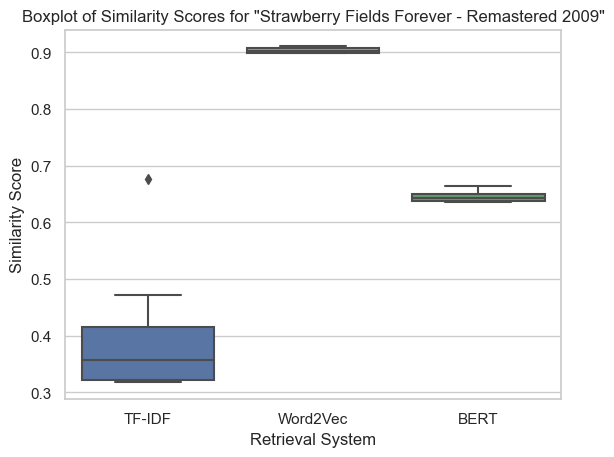

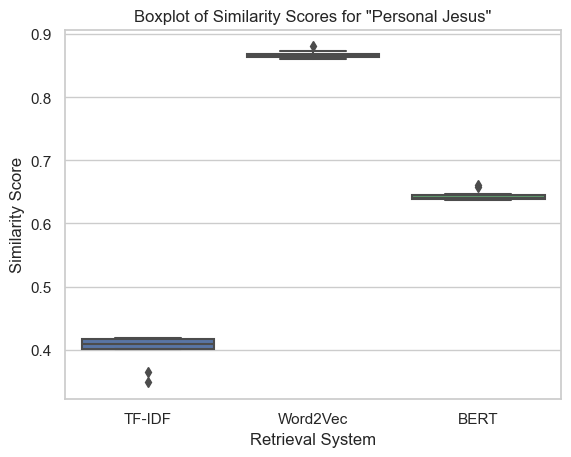

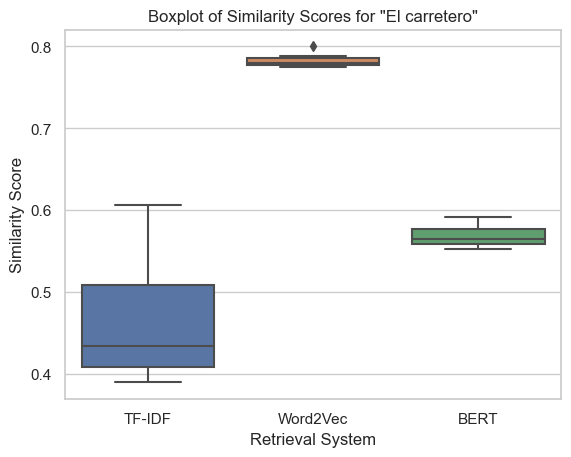

In [23]:
# Plot the results
plot_boxplot_similarity_scores(query=track_1)
plot_boxplot_similarity_scores(query=track_2)
plot_boxplot_similarity_scores(query=track_3)

In [24]:
def plot_all_similarity_scores(query): 
    song_title = query['song']
    query_id = query['id']
    similarity_scores_df = pd.read_csv(f'similarity_scores_{query_id}.csv')
    
    long_df = similarity_scores_df.melt(var_name='System', value_name='Similarity Score')
    
    sns.swarmplot(x='System', y='Similarity Score', data=long_df, size=5, palette='bright', alpha=0.7) #avoids overlapping points
    
    plt.title(f'Individual Similarity Scores for "{song_title}"')
    plt.xlabel('Retrieval System')
    plt.ylabel('Similarity Score')
    plt.tight_layout()
    plt.show()


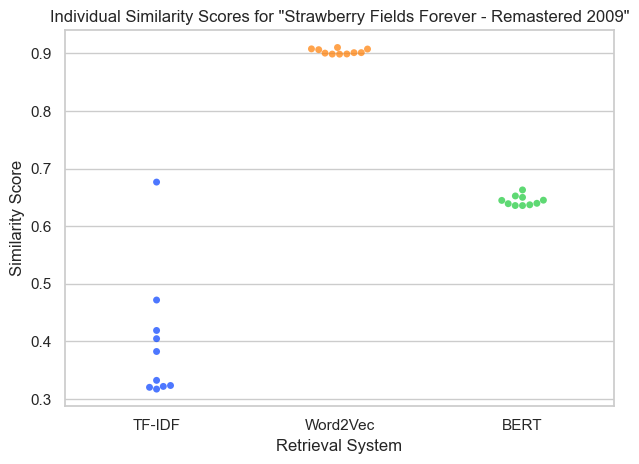

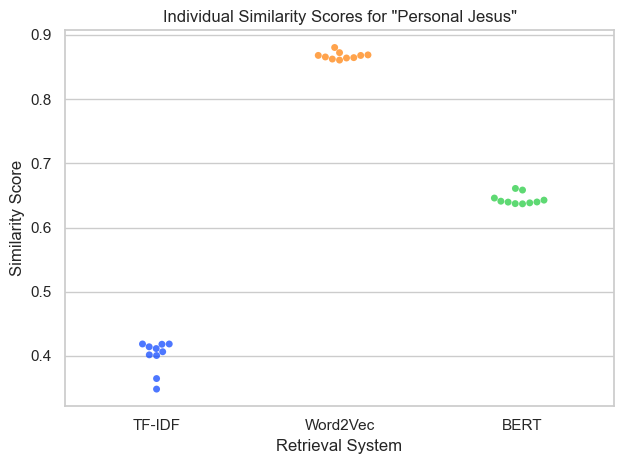

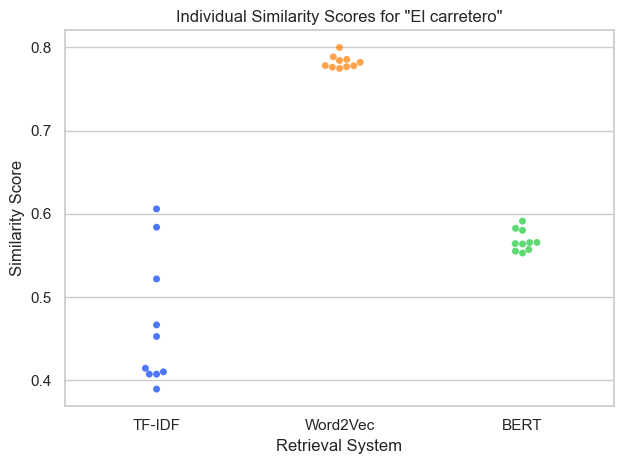

In [25]:
plot_all_similarity_scores(query=track_1)
plot_all_similarity_scores(query=track_2)
plot_all_similarity_scores(query=track_3)